## RFM & Clustering

### Set-Up

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import plotly.graph_objects as go


In [3]:
# file path
file_path = r"C:\Users\agste\.cache\kagglehub\datasets\carrie1\ecommerce-data\versions\1\data.csv"

# read csv file using polars & cast InvoiceDate to datetime
df = pl.read_csv(file_path, encoding="ISO-8859-1", ignore_errors=True).with_columns(
    pl.col("InvoiceDate").str.to_datetime("%m/%d/%Y %H:%M", strict=False)
)

# display first few rows
df.head()

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
i64,str,str,i64,datetime[μs],f64,i64,str
536365,"""85123A""","""WHITE HANGING HEART T-LIGHT HO…",6,2010-12-01 08:26:00,2.55,17850,"""United Kingdom"""
536365,"""71053""","""WHITE METAL LANTERN""",6,2010-12-01 08:26:00,3.39,17850,"""United Kingdom"""
536365,"""84406B""","""CREAM CUPID HEARTS COAT HANGER""",8,2010-12-01 08:26:00,2.75,17850,"""United Kingdom"""
536365,"""84029G""","""KNITTED UNION FLAG HOT WATER B…",6,2010-12-01 08:26:00,3.39,17850,"""United Kingdom"""
536365,"""84029E""","""RED WOOLLY HOTTIE WHITE HEART.""",6,2010-12-01 08:26:00,3.39,17850,"""United Kingdom"""


### Data Preparation

In [4]:
# drop nulls by key columns (order id & customer id)
df = df.drop_nulls(["InvoiceNo", "CustomerID"]).unique()  # remove duplicates

In [5]:
# create a new columns Monetary = Quantity * Unit Price (for RFM analysis)
df = df.with_columns(pl.col("Quantity").mul(pl.col("UnitPrice")).alias("Monetary"))
df.head()

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
i64,str,str,i64,datetime[μs],f64,i64,str,f64
541406,"""21470""","""FLOWER VINE RAFFIA FOOD COVER""",1,2011-01-17 15:19:00,3.75,14657,"""United Kingdom""",3.75
541574,"""21086""","""SET/6 RED SPOTTY PAPER CUPS""",12,2011-01-19 12:52:00,0.65,12826,"""United Kingdom""",7.8
573264,"""22578""","""WOODEN STAR CHRISTMAS SCANDINA…",10,2011-10-28 12:36:00,0.29,14415,"""United Kingdom""",2.9
575367,"""22603""","""CHRISTMAS RETROSPOT TREE WOOD""",12,2011-11-09 15:05:00,0.85,15114,"""United Kingdom""",10.2
573934,"""22665""","""RECIPE BOX BLUE SKETCHBOOK DES…",6,2011-11-02 10:36:00,2.95,17719,"""United Kingdom""",17.7


In [6]:
# check the distribution of characters of the Stock-code column -- maybe need to strange stock codes/outliers
df.with_columns(pl.col("StockCode").str.len_chars().alias("number_of_char")).group_by(
    pl.col("number_of_char")
).len().sort("*")

# 1: D & M
# 2: what is Carriage?
# 3: DOTCOM POSTAGE (DOT)
# 4: POSTAGE (POST)
# 5: OK
# 6: OK
# 7: OK
# 8: strange
# 9: strange
# 12: strange

number_of_char,len
u32,u32
1,285
2,133
3,16
4,1103
5,358309
6,32583
7,291
12,12


In [7]:
# create a list with the number of length of characters to accept
acceptable_number_of_chars = [5, 6, 7]
# filter out stock codes with length of 5,6,7 (that make sense) and drop the number_of_char column
df = (
    df.with_columns(pl.col("StockCode").str.len_chars().alias("number_of_char"))
    .filter(pl.col("number_of_char").is_in(acceptable_number_of_chars))
    .drop(["number_of_char"])
)

In [8]:
df

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
i64,str,str,i64,datetime[μs],f64,i64,str,f64
541406,"""21470""","""FLOWER VINE RAFFIA FOOD COVER""",1,2011-01-17 15:19:00,3.75,14657,"""United Kingdom""",3.75
541574,"""21086""","""SET/6 RED SPOTTY PAPER CUPS""",12,2011-01-19 12:52:00,0.65,12826,"""United Kingdom""",7.8
573264,"""22578""","""WOODEN STAR CHRISTMAS SCANDINA…",10,2011-10-28 12:36:00,0.29,14415,"""United Kingdom""",2.9
575367,"""22603""","""CHRISTMAS RETROSPOT TREE WOOD""",12,2011-11-09 15:05:00,0.85,15114,"""United Kingdom""",10.2
573934,"""22665""","""RECIPE BOX BLUE SKETCHBOOK DES…",6,2011-11-02 10:36:00,2.95,17719,"""United Kingdom""",17.7
…,…,…,…,…,…,…,…,…
577748,"""20674""","""GREEN POLKADOT BOWL""",8,2011-11-21 14:24:00,1.25,15159,"""United Kingdom""",10.0
553134,"""23209""","""LUNCH BAG DOILEY PATTERN """,10,2011-05-13 12:50:00,1.65,15382,"""United Kingdom""",16.5
544717,"""22557""","""PLASTERS IN TIN VINTAGE PAISLE…",12,2011-02-23 10:44:00,1.65,18172,"""United Kingdom""",19.8


In [9]:
df.with_columns(
    pl.col("StockCode").str.extract(r"^([A-Za-z])").alias("FirstChar")
).filter(
    pl.col("FirstChar").is_not_null()
)  # .group_by("FirstChar").len()

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,FirstChar
i64,str,str,i64,datetime[μs],f64,i64,str,f64,str


In [10]:
df.head()

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
i64,str,str,i64,datetime[μs],f64,i64,str,f64
541406,"""21470""","""FLOWER VINE RAFFIA FOOD COVER""",1,2011-01-17 15:19:00,3.75,14657,"""United Kingdom""",3.75
541574,"""21086""","""SET/6 RED SPOTTY PAPER CUPS""",12,2011-01-19 12:52:00,0.65,12826,"""United Kingdom""",7.8
573264,"""22578""","""WOODEN STAR CHRISTMAS SCANDINA…",10,2011-10-28 12:36:00,0.29,14415,"""United Kingdom""",2.9
575367,"""22603""","""CHRISTMAS RETROSPOT TREE WOOD""",12,2011-11-09 15:05:00,0.85,15114,"""United Kingdom""",10.2
573934,"""22665""","""RECIPE BOX BLUE SKETCHBOOK DES…",6,2011-11-02 10:36:00,2.95,17719,"""United Kingdom""",17.7


In [11]:
df.describe()

statistic,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
str,f64,str,str,f64,str,f64,f64,str,f64
"""count""",391183.0,"""391183""","""391183""",391183.0,"""391183""",391183.0,391183.0,"""391183""",391183.0
"""null_count""",0.0,"""0""","""0""",0.0,"""0""",0.0,0.0,"""0""",0.0
"""mean""",560592.915888,null,null,13.179665,"""2011-07-10 19:37:28.017628""",2.87413,15295.083503,null,22.335397
"""std""",13087.309975,null,null,181.907403,null,4.284639,1710.359579,null,310.919394
"""min""",536365.0,"""10002""",""" 4 PURPLE FLOCK DINNER CANDLES""",1.0,"""2010-12-01 08:26:00""",0.0,12346.0,"""Australia""",0.0
"""25%""",549235.0,null,null,2.0,"""2011-04-07 11:16:00""",1.25,13969.0,null,4.95
"""50%""",561875.0,null,null,6.0,"""2011-07-31 12:05:00""",1.95,15158.0,null,11.9
"""75%""",572063.0,null,null,12.0,"""2011-10-20 12:57:00""",3.75,16794.0,null,19.8
"""max""",581587.0,"""90214Z""","""ZINC WIRE SWEETHEART LETTER TR…",80995.0,"""2011-12-09 12:50:00""",649.5,18287.0,"""Unspecified""",168469.6


In [12]:
# remove orders with 0 Monetary value
df = df.filter(~pl.col("Monetary").eq(0))

In [13]:
df.head()

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary
i64,str,str,i64,datetime[μs],f64,i64,str,f64
541406,"""21470""","""FLOWER VINE RAFFIA FOOD COVER""",1,2011-01-17 15:19:00,3.75,14657,"""United Kingdom""",3.75
541574,"""21086""","""SET/6 RED SPOTTY PAPER CUPS""",12,2011-01-19 12:52:00,0.65,12826,"""United Kingdom""",7.8
573264,"""22578""","""WOODEN STAR CHRISTMAS SCANDINA…",10,2011-10-28 12:36:00,0.29,14415,"""United Kingdom""",2.9
575367,"""22603""","""CHRISTMAS RETROSPOT TREE WOOD""",12,2011-11-09 15:05:00,0.85,15114,"""United Kingdom""",10.2
573934,"""22665""","""RECIPE BOX BLUE SKETCHBOOK DES…",6,2011-11-02 10:36:00,2.95,17719,"""United Kingdom""",17.7


In [14]:
from datetime import datetime, timedelta

# cast Invoice date column to Date object
df = df.with_columns(pl.col("InvoiceDate").cast(pl.Date))

### RFM Segments

In [15]:
## define the improved segmentation map with logical customer groups
# segment_map = {
#    "Champions": ["443", "434", "344", "444"],
#    "Loyal_Customers": ["433", "343", "334", "333"],
#    "Potential_Customers": ["442", "424", "423", "342", "324"],
#    "Potential_Big_Spenders": ["432", "422", "234", "233", "232", "244", "243"],
#    "Newcomers": ["144", "134", "414", "413", "314", "313", "114", "214"],
#    "At_Risk_Customers": ["441", "341", "241"],
#    "Win_Back_Targets": ["322", "323", "224", "223", "222", "312", "212", "142", "412", "213"],
#    "Fading_Customers": ["332", "242", "431", "421", "331", "231"],
#    "Lost Customers": ["411", "321", "311", "221", "211", "141", "131", "124", "123", "122", "121", "111", "112", "113", "133", "143", "132"]
# }
#
## reverse the mapping to allow lookup by RFM_Score
# rfm_segment_lookup = {rfm: segment for segment, rfms in segment_map.items() for rfm in rfms}
#
## convert the segment map into a Polars DataFrame
# rfm_segment_lookup = pl.DataFrame({
#    "RFM_Score": [rfm for rfms in segment_map.values() for rfm in rfms],
#    "Segment": [segment for segment, rfms in segment_map.items() for _ in rfms]
# })
#
## save to .csv file
# output_path = r"C:\Users\agste\.cache\rfm_segments.csv"
# rfm_segment_lookup.write_csv(output_path)

### RFM Analysis

In [16]:
# define max date of the dataset
max_date = df["InvoiceDate"].max()

# set reference date: last day of the previous month from max date which is set as upper threshold of the analysis


ref_date = max_date.replace(day=1) - timedelta(days=1)

In [17]:
output_path = r"C:\Users\agste\.cache\rfm_segments.csv"
# load rfm segment table
rfm_segments = pl.read_csv(output_path)

In [18]:
import polars as pl


def rfm_model(
    df: pl.DataFrame,
    ref_date: pl.Date,
    segments_df: pl.DataFrame,
    output_columns: list = ["CustomerID", "Segment"],
) -> pl.DataFrame:
    """
    Calculate RFM scores and map them to customer segments.

    Parameters:
    - df (pl.DataFrame): The transaction data containing "CustomerID", "InvoiceDate", "InvoiceNo", and "Monetary".
    - ref_date (str): The reference date to calculate "Recency" (format: "YYYY-MM-DD").
    - segments_df (pl.DataFrame): A lookup table mapping RFM scores to segments.
    - output_columns (list, optional): The list of columns to return. Default: ["CustomerID", "Segment"], # ["Recency", "Frequency", "Monetary", "R", "F", "M", "RFM_Score"]

    Returns:
    - pl.DataFrame: The resulting dataset containing RFM metrics and segments.
    """

    # aggregate RFM metrics
    rfm_data = (
        df.filter(pl.col("InvoiceDate").le(ref_date))
        .group_by("CustomerID")
        .agg(
            (pl.lit(ref_date) - pl.col("InvoiceDate").max())
            .dt.total_days()
            .alias("Recency"),  # Days since last purchase
            pl.col("InvoiceNo")
            .n_unique()
            .alias("Frequency"),  # Number of unique purchases
            pl.col("Monetary").sum().alias("Monetary"),  # Total spend
        )
    )

    # RFM quantiles
    rfm_cols = ["Recency", "Frequency", "Monetary"]
    rfm_data = rfm_data.with_columns(
        [
            pl.col(column)
            .qcut(
                quantiles=4,
                labels=["1", "2", "3", "4"],
                left_closed=False,
                allow_duplicates=False,
            )
            .cast(pl.Int8)
            .alias(column[0])  # Rename to R, F, M
            for column in rfm_cols
        ]
    )

    # reverse R score for Recency (since lower Recency is better)
    rfm_data = rfm_data.with_columns([(5 - pl.col("R")).alias("R")])

    # create RFM Score column
    rfm_data = rfm_data.with_columns(
        pl.concat_str([pl.col("R"), pl.col("F"), pl.col("M")]).alias("RFM_Score")
    )

    # ensure RFM_Score in segments_df is string type
    segments_df = segments_df.cast({"RFM_Score": pl.Utf8})

    # join with RFM segments lookup table
    rfm_data = rfm_data.join(segments_df, on="RFM_Score", how="left", validate="m:1")

    # define fixed columns that must always appear first
    fixed_columns = ["CustomerID", "Segment"]

    # ensure additional columns are valid and exist in the dataset
    if output_columns:
        output_columns = [
            col
            for col in output_columns
            if col in rfm_data.columns and col not in fixed_columns
        ]
    else:
        output_columns = []

    # ensure final column order: CustomerID, Segment, followed by user-selected columns
    final_columns = fixed_columns + output_columns

    # Return only the requested columns
    return rfm_data.select(final_columns)

In [19]:
# To include RFM scores and metrics in output:
rfm_output = rfm_model(
    df=df,
    ref_date=ref_date,
    segments_df=rfm_segments,
    output_columns=["Recency", "Frequency", "Monetary"],
)

In [20]:
rfm_output.head()

CustomerID,Segment,Recency,Frequency,Monetary
i64,str,i64,u32,f64
17462,"""Win_Back_Targets""",51,2,675.69
15497,"""Potential_Customers""",8,2,1262.2
14702,"""Champions""",9,15,2926.11
17700,"""Champions""",7,4,2534.64
13898,"""Lost Customers""",316,1,155.93


In [21]:
rfm_output["Segment"].value_counts().sort("count", descending=True)

Segment,count
str,u32
"""Lost Customers""",1519
"""Champions""",844
"""Win_Back_Targets""",696
"""Potential_Big_Spenders""",518
"""Loyal_Customers""",424
"""Fading_Customers""",120
"""Newcomers""",97
"""Potential_Customers""",73
"""At_Risk_Customers""",2


In [22]:
rfm_summary = rfm_output.group_by("Segment").agg(
    pl.len().alias("Count"),
    pl.col("Recency").mean().round(2),
    pl.col("Frequency").mean().round(2),
    pl.col("Monetary").mean().round(2),
)
rfm_summary

Segment,Count,Recency,Frequency,Monetary
str,u32,f64,f64,f64
"""Lost Customers""",1519,181.48,1.35,320.31
"""Potential_Big_Spenders""",518,64.38,4.08,1439.21
"""Champions""",844,13.07,11.76,6531.11
"""Fading_Customers""",120,31.96,2.98,353.91
"""Potential_Customers""",73,12.1,2.48,1205.26
"""Win_Back_Targets""",696,62.22,1.52,630.59
"""Loyal_Customers""",424,22.22,3.93,1287.41
"""At_Risk_Customers""",2,73.5,6.5,135.57
"""Newcomers""",97,119.24,2.65,3765.04


In [23]:
import plotly.express as px

# Creating the first plot: Count vs. Monetary value per segment
fig1 = px.bar(rfm_summary, x="Segment", y="Monetary", color="Segment",
              title="Monetary Value per RFM Segment (Colored by Count)",
              labels={"Monetary": "Total Monetary Value", "Segment": "Customer Segment"},
              text="Monetary")
fig1.show()

In [24]:
# Creating the second plot: Recency vs. Frequency with size representing Monetary
fig2 = px.scatter(rfm_summary, x="Recency", y="Frequency", size="Monetary", color="Segment",
                  title="Recency vs Frequency (Bubble Size Represents Monetary Value)",
                  labels={"Recency": "Average Recency (Days)", "Frequency": "Purchase Frequency"},
                  hover_name="Segment")
fig2.show()


In [25]:
# create new column: average basket size
rfm_summary = rfm_summary.with_columns(
    pl.col("Monetary")
    .truediv(pl.col("Frequency"))
    .round(2)
    .alias("Average_Basket_Value")
)

In [26]:
# Creating the fourth plot: Frequency to Monetary Ratio per segment
fig3 = px.bar(
    rfm_summary,
    x="Segment",
    y="Average_Basket_Value",
    color="Count",
    title="Frequency to Monetary Ratio per Segment",
    labels={
        "Average_Basket_Value": "Average_Basket_Value",
        "Segment": "Customer Segment",
    },
    text="Average_Basket_Value",
)
fig3.show()

### K-Means

In [27]:
rfm_output.head()

CustomerID,Segment,Recency,Frequency,Monetary
i64,str,i64,u32,f64
17462,"""Win_Back_Targets""",51,2,675.69
15497,"""Potential_Customers""",8,2,1262.2
14702,"""Champions""",9,15,2926.11
17700,"""Champions""",7,4,2534.64
13898,"""Lost Customers""",316,1,155.93


In [28]:
# select R, F, M features and CustomerID which is set as index of the pandas data frame
df_pandas = (
    rfm_output.select(["CustomerID", "Recency", "Frequency", "Monetary"])
    .to_pandas()
    .set_index("CustomerID")
)

In [29]:
# standardize the data for better clustering performance
scaler = StandardScaler()
df_pandas_scaled = scaler.fit_transform(df_pandas)

In [30]:
# Determine the optimal k using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(4, 10)  # Testing k from 4 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pandas_scaled)
    inertia.append(kmeans.inertia_)  # Inertia (Sum of Squared Distances)
    silhouette_scores.append(
        silhouette_score(df_pandas_scaled, kmeans.labels_)
    )  # Silhouette Score

In [31]:
# Create an interactive Plotly figure for the Elbow Method
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(k_range),
    y=inertia,
    mode='lines+markers',
    marker=dict(size=8, color='blue'),
    line=dict(width=2),
    name='Inertia'
))

# Customize layout
fig.update_layout(
    title="Elbow Method for Optimal k",
    xaxis_title="Number of Clusters (k)",
    yaxis_title="Inertia",
    template="plotly_white",
    hovermode="x"
)

# Display the interactive plot
fig.show()

In [32]:
# Create an interactive Plotly figure for the Silhouette Score analysis
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(k_range),
    y=silhouette_scores,
    mode='lines+markers',
    marker=dict(size=8, color='green'),
    line=dict(width=2),
    name='Silhouette Score'
))

# Customize layout
fig.update_layout(
    title="Silhouette Score Analysis",
    xaxis_title="Number of Clusters (k)",
    yaxis_title="Silhouette Score",
    template="plotly_white",
    hovermode="x"
)

# Display the interactive plot
fig.show()

In [33]:
# choose the best k based on the Elbow and Silhouette Score analysis
optimal_k = 4  # Adjust based on previous plots

# Fit the final K-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(df_pandas_scaled)

# Add the cluster labels to the original RFM DataFrame
rfm_output = rfm_output.with_columns(pl.Series(name="Cluster", values=kmeans_clusters))

In [34]:
rfm_output["Cluster"].value_counts().sort("*")

Cluster,count
i32,u32
0,2988
1,11
2,1098
3,196


In [35]:
rfm_output

CustomerID,Segment,Recency,Frequency,Monetary,Cluster
i64,str,i64,u32,f64,i32
17462,"""Win_Back_Targets""",51,2,675.69,0
15497,"""Potential_Customers""",8,2,1262.2,0
14702,"""Champions""",9,15,2926.11,3
17700,"""Champions""",7,4,2534.64,0
13898,"""Lost Customers""",316,1,155.93,2
…,…,…,…,…,…
14142,"""Lost Customers""",364,1,311.81,2
16494,"""Lost Customers""",287,1,826.53,2
15059,"""Loyal_Customers""",31,9,1337.72,0


In [36]:
rfm_output.group_by("Cluster").agg(
    pl.len().alias(
        "Count"),
        pl.col("Recency").mean().round(2),
        pl.col("Frequency").mean().round(2),
        pl.col("Monetary").mean().round(2),
    ).sort("Monetary")

Cluster,Count,Recency,Frequency,Monetary
i32,u32,f64,f64,f64
2,1098,240.2,1.54,469.58
0,2988,40.92,3.59,1300.49
3,196,16.05,21.57,12703.14
1,11,5.36,90.36,121248.73


In [37]:
# define the cluster-to-name mapping
cluster_names = {
    0: "One_Time_Shoppers",
    1: "Steady_Buyers", 
    2: "Elite_Spenders",
    3: "VIP_Customers" 
}

In [38]:
# assign cluster names
rfm_output = rfm_output.with_columns(
    pl.col("Cluster")
    .map_elements(lambda x: cluster_names.get(x, "Unknown"), return_dtype=pl.Utf8)
    .alias("Cluster_Name")
)

In [39]:
rfm_output

CustomerID,Segment,Recency,Frequency,Monetary,Cluster,Cluster_Name
i64,str,i64,u32,f64,i32,str
17462,"""Win_Back_Targets""",51,2,675.69,0,"""One_Time_Shoppers"""
15497,"""Potential_Customers""",8,2,1262.2,0,"""One_Time_Shoppers"""
14702,"""Champions""",9,15,2926.11,3,"""VIP_Customers"""
17700,"""Champions""",7,4,2534.64,0,"""One_Time_Shoppers"""
13898,"""Lost Customers""",316,1,155.93,2,"""Elite_Spenders"""
…,…,…,…,…,…,…
14142,"""Lost Customers""",364,1,311.81,2,"""Elite_Spenders"""
16494,"""Lost Customers""",287,1,826.53,2,"""Elite_Spenders"""
15059,"""Loyal_Customers""",31,9,1337.72,0,"""One_Time_Shoppers"""


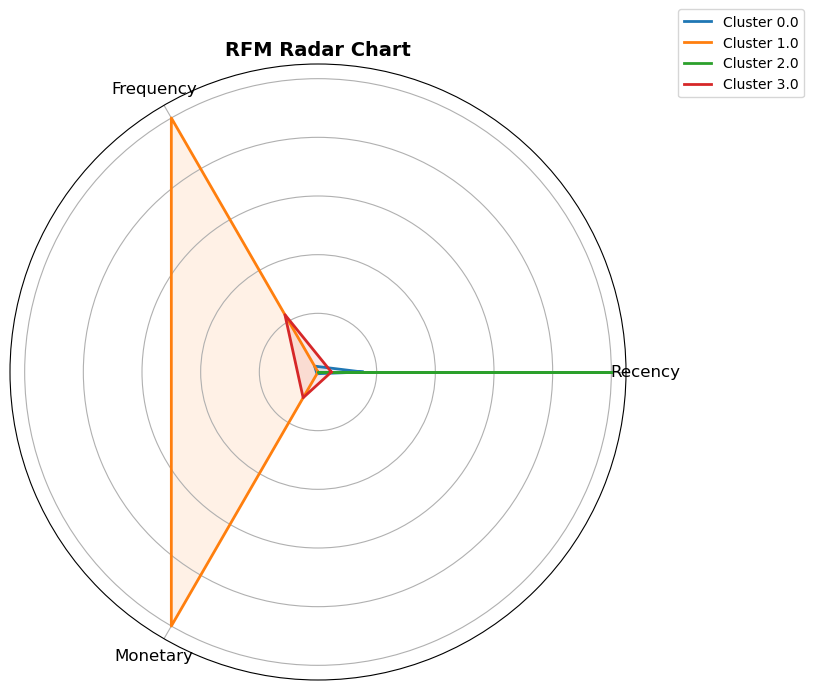

In [40]:
# Convert Polars DataFrame to Pandas for visualization
rfm_clusters_summary_pd = rfm_output.group_by("Cluster").agg(
    pl.len().alias(
        "Count"),
        pl.col("Recency").mean().round(2),
        pl.col("Frequency").mean().round(2),
        pl.col("Monetary").mean().round(2),
    ).sort("Cluster").to_pandas()

# Define labels for the radar chart (RFM features)
categories = ["Recency", "Frequency", "Monetary"]
num_vars = len(categories)

# Normalize values for better visualization (Min-Max Scaling)
rfm_clusters_summary_pd[categories] = rfm_clusters_summary_pd[categories].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Radar chart function
def plot_radar_chart(df, categories, title="RFM Radar Chart"):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for i, row in df.iterrows():
        values = row[categories].tolist()
        values += values[:1]  # Close the shape
        label = row["Cluster_Name"] if "Cluster_Name" in df.columns else f"Cluster {row['Cluster']}"
        ax.plot(angles, values, label=label, linewidth=2)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_yticklabels([])  # Hide Y ticks
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Plot the radar chart for all clusters
plot_radar_chart(rfm_clusters_summary_pd, categories)

### Functions

In [41]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def find_optimal_k(df, id_col="CustomerID", features=["Recency", "Frequency", "Monetary"], 
                    metrics=["inertia", "silhouette_scores"], show_plots=True):
    """
    Function to determine the optimal number of clusters for KMeans using the Elbow Method and Silhouette Score.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing customer data.
        id_col (str): Column name to be used as index.
        features (list): List of columns to use for clustering.
        metrics (list): Metrics to compute (options: "inertia", "silhouette_scores").
        show_plots (bool): Whether to display the plots.
    
    Returns:
        int: Optimal number of clusters based on the Elbow Method and Silhouette Score.
    """
    # Set index and select relevant features
    df_pandas = df.to_pandas().set_index(id_col)[features]
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_pandas)
    
    # Determine the optimal k using the Elbow Method and Silhouette Score
    inertia = []
    silhouette_scores = []
    k_range = list(range(4, 10))  # Testing k from 4 to 10

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_scaled)
        
        if "inertia" in metrics:
            inertia.append(kmeans.inertia_)  # Inertia (Sum of Squared Distances)
        if "silhouette_scores" in metrics:
            silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))  # Silhouette Score
    
    # Plot Elbow Method
    if show_plots and "inertia" in metrics:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=k_range,
            y=inertia,
            mode='lines+markers',
            marker=dict(size=8, color='blue'),
            line=dict(width=2),
            name='Inertia'
        ))
        fig.update_layout(
            title="Elbow Method for Optimal k",
            xaxis_title="Number of Clusters (k)",
            yaxis_title="Inertia",
            template="plotly_white",
            hovermode="x"
        )
        fig.show()
    
    # Plot Silhouette Score
    if show_plots and "silhouette_scores" in metrics:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=k_range,
            y=silhouette_scores,
            mode='lines+markers',
            marker=dict(size=8, color='green'),
            line=dict(width=2),
            name='Silhouette Score'
        ))
        fig.update_layout(
            title="Silhouette Score Analysis",
            xaxis_title="Number of Clusters (k)",
            yaxis_title="Silhouette Score",
            template="plotly_white",
            hovermode="x"
        )
        fig.show()
    
    # Determine the optimal number of clusters
    if "inertia" in metrics and "silhouette_scores" in metrics:
        optimal_k = k_range[inertia.index(min(inertia))] if min(inertia) < max(silhouette_scores) else k_range[silhouette_scores.index(max(silhouette_scores))]
    elif "inertia" in metrics:
        optimal_k = k_range[inertia.index(min(inertia))]
    elif "silhouette_scores" in metrics:
        optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    else:
        raise ValueError("No valid metric provided for optimal k selection")
    
    return optimal_k

In [42]:
find_optimal_k(rfm_output, id_col="CustomerID", features=["Recency", "Frequency", "Monetary"], metrics=["silhouette_scores", "inertia"], show_plots=True)

4

In [43]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

def grid_search_kmeans(df, id_col="CustomerID", features=["Recency", "Frequency", "Monetary"], 
                        param_grid=None, cv=5):
    """
    Perform grid search for K-Means clustering parameters and minimize the silhouette score.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing customer data.
        id_col (str): Column name to be used as index.
        features (list): List of columns to use for clustering.
        param_grid (dict): Dictionary containing the hyperparameter grid for KMeans.
        cv (int): Number of cross-validation folds (default=5).
    
    Returns:
        dict: Best hyperparameters found through grid search.
    """
    if param_grid is None:
        param_grid = {
            "n_clusters": [4, 5, 6, 7, 8, 9, 10],
            "n_init": [10, 20, 50, 100, 200, 500],
            "max_iter": [250, 500, 1000, 1500],
        }
    
    # Set index and select relevant features
    df_pandas = df.to_pandas().set_index(id_col)[features]
    
    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_pandas)
    
    # Define a custom scoring function that calculates silhouette score
    def silhouette_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        return silhouette_score(X, labels)
    
    # Create a KMeans instance
    kmeans = KMeans(random_state=42)
    
    # Perform grid search with custom scoring function
    grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_scorer, cv=cv, n_jobs=-1)
    grid_search.fit(df_scaled)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    
    # Get the maximum silhouette score
    best_labels = best_estimator.fit_predict(df_scaled)
    max_silhouette_score = silhouette_score(df_scaled, best_labels)
    
    return best_params, best_estimator, max_silhouette_score

In [44]:
# example if param_grid is not None - define a custom parameter grid
#custom_param_grid = {
#    "n_clusters": [3, 4, 5, 6],  # Only testing 4 cluster values
#    "n_init": [10, 50],  # Trying fewer `n_init` values
#    "max_iter": [500, 1000],  # Testing two `max_iter` values
#    "tol": [1e-3],  # Fixing tolerance to a single value
#    "algorithm": ["elkan"],  # Only using "elkan" optimization
#    "init": ["k-means++"]  # Only using "k-means++" initialization
#}

In [45]:
grid_search_kmeans(rfm_output, id_col="CustomerID", features=["Recency", "Frequency", "Monetary"], param_grid=None, cv=5)

({'max_iter': 250, 'n_clusters': 4, 'n_init': 50},
 KMeans(max_iter=250, n_clusters=4, n_init=50, random_state=42),
 0.6108568832810244)